# Gomoku game

1. [DONE] Implement the Gomoku game rule, such as checking whether a position is the end of the game.
2. [DONE] Implement a heuristic rule-based policy.
3. [DONE] Implement an interactive playing UI to verify whether a policy works.
4. [DONE] Use supervised learning to learn the rule-based policy at move level.
5. [DONE] Implement a head-to-head evaluation to compare the performance of the policies.
6. [DONE] Use reinforcement learning to learn a policy against itself.

In [103]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Callable, Any
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod

In [2]:
NUM_IN_ROW_TO_WIN = 5
BOARD_LENGTH = 11

In [3]:
def spiral_order(length) -> torch.Tensor:
  assert length % 2 == 1, "spiral_order only works for odd length"
  spiral_order = torch.zeros([length, length], dtype=torch.int64)
  x, y = length // 2, length // 2
  dx, dy = 0, 1
  try:
    for i in range(length * length):
      spiral_order[x, y] = i + 1
      if spiral_order[x + dy, y - dx] == 0:  # x + dx >= length or x + dx < 0 or y + dy >= length or y + dy < 0 or 
        dx, dy = dy, -dx
      x, y = x + dx, y + dy
  except IndexError:
    print(f"IndexError at {x}, {y}, i={i}, spiral_order={spiral_order}")
  return spiral_order

spiral_order(BOARD_LENGTH)

tensor([[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
        [100,  65,  66,  67,  68,  69,  70,  71,  72,  73, 112],
        [ 99,  64,  37,  38,  39,  40,  41,  42,  43,  74, 113],
        [ 98,  63,  36,  17,  18,  19,  20,  21,  44,  75, 114],
        [ 97,  62,  35,  16,   5,   6,   7,  22,  45,  76, 115],
        [ 96,  61,  34,  15,   4,   1,   8,  23,  46,  77, 116],
        [ 95,  60,  33,  14,   3,   2,   9,  24,  47,  78, 117],
        [ 94,  59,  32,  13,  12,  11,  10,  25,  48,  79, 118],
        [ 93,  58,  31,  30,  29,  28,  27,  26,  49,  80, 119],
        [ 92,  57,  56,  55,  54,  53,  52,  51,  50,  81, 120],
        [ 91,  90,  89,  88,  87,  86,  85,  84,  83,  82, 121]])

In [4]:
def is_win(
    position: torch.LongTensor,
    point: torch.LongTensor,
  ) -> bool:
  '''Check whether the position is at a terminating status.
  Args:
    position: A Tensor of shape [B, BOARD_LENGTH, BOARD_LENGTH] which has value 0, 1, and 2 for each element.
      0 means the point is not ocupied and available to play on. 1 mean that the point is taken by player 1,
      and 2 means that the point is taken by player 2.
    point: A Tensor [B, 2], which carries the 0-based row and column of the point that is last played. The
      position should be already updated with the last play, which means that position[point] should be either
      1 or 2 and cannot be 0.
  '''
  
  # check row
  x_len = 1
  for y_diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[1] + y_diff < BOARD_LENGTH and position[point[0], point[1] + y_diff] == position[point[0], point[1]]:
      x_len += 1
    else:
      break
  for y_diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[1] + y_diff >= 0 and position[point[0], point[1] + y_diff] == position[point[0], point[1]]:
      x_len += 1
    else:
      break
  if x_len >= NUM_IN_ROW_TO_WIN:
    return True
  
  # check column
  y_len = 1
  for x_diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + x_diff < BOARD_LENGTH and position[point[0] + x_diff, point[1]] == position[point[0], point[1]]:
      y_len += 1
    else:
      break
  for x_diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + x_diff >= 0 and position[point[0] + x_diff, point[1]] == position[point[0], point[1]]:
      y_len += 1
    else:
      break
  if y_len >= NUM_IN_ROW_TO_WIN:
    return True

  # check top-right bottom-left diagonal
  diag_len = 1
  for diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + diff < BOARD_LENGTH and point[1] + diff < BOARD_LENGTH and position[point[0] + diff, point[1] + diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  for diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + diff >= 0 and point[1] + diff >= 0 and position[point[0] + diff, point[1] + diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  if diag_len >= NUM_IN_ROW_TO_WIN:
    return True

  # check top-left bottom-right diagonal
  diag_len = 1
  for diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + diff < BOARD_LENGTH and point[1] - diff >= 0 and position[point[0] + diff, point[1] - diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  for diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + diff >= 0 and point[1] - diff < BOARD_LENGTH and position[point[0] + diff, point[1] - diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  if diag_len >= NUM_IN_ROW_TO_WIN:
    return True

  return False


def test_is_win():
  position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32)
  position[0, 0] = 1
  position[1, 0] = 1
  position[2, 0] = 1
  position[3, 0] = 1
  position[4, 0] = 1
  assert is_win(position, torch.tensor([4, 0]))
  position[4, 0] = 0
  position[0, 0] = 0
  position[0, 1] = 1
  position[0, 2] = 1
  position[0, 3] = 1
  position[0, 4] = 1
  position[0, 5] = 1
  assert is_win(position, torch.tensor([0, 3]))
  position[0, 0] = 1
  position[1, 1] = 1
  position[2, 2] = 1
  position[3, 3] = 1
  position[4, 4] = 1
  assert is_win(position, torch.tensor([1, 1]))
  position[4, 4] = 0
  position[5, 4] = 2
  position[6, 3] = 2
  position[7, 2] = 2
  position[8, 1] = 2
  position[9, 0] = 2
  assert is_win(position, torch.tensor([9, 0]))
  assert not is_win(position, torch.tensor([3, 0]))
  print('All test passed!')


test_is_win()

All test passed!


In [5]:
def win_filter() -> torch.LongTensor:  
  row_filter = torch.zeros([NUM_IN_ROW_TO_WIN, NUM_IN_ROW_TO_WIN], dtype=torch.long)
  row_filter[NUM_IN_ROW_TO_WIN // 2] = 1
  column_filter = torch.zeros([NUM_IN_ROW_TO_WIN, NUM_IN_ROW_TO_WIN], dtype=torch.long)
  column_filter[:, NUM_IN_ROW_TO_WIN // 2] = 1
  diag_filter = torch.zeros([NUM_IN_ROW_TO_WIN, NUM_IN_ROW_TO_WIN], dtype=torch.long)
  diag_filter[range(NUM_IN_ROW_TO_WIN), range(NUM_IN_ROW_TO_WIN)] = 1
  anti_diag_filter = torch.zeros([NUM_IN_ROW_TO_WIN, NUM_IN_ROW_TO_WIN], dtype=torch.long)
  anti_diag_filter[range(NUM_IN_ROW_TO_WIN), range(NUM_IN_ROW_TO_WIN)[::-1]] = 1
  return torch.stack([row_filter, column_filter, diag_filter, anti_diag_filter]).unsqueeze(1)

_is_win_filter = win_filter()

def is_player_win(position: torch.LongTensor, player: int) -> bool:
  p = (position == player).long().unsqueeze(0).unsqueeze(0)
  conved = F.conv2d(p, _is_win_filter, padding=NUM_IN_ROW_TO_WIN // 2)
  return torch.any(conved == NUM_IN_ROW_TO_WIN).detach().item()


def test_is_player_win():
  position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32)
  position[0, 0] = 1
  position[1, 0] = 1
  position[2, 0] = 1
  position[3, 0] = 1
  assert not is_player_win(position, 1)
  position[4, 0] = 1
  assert is_player_win(position, 1)
  assert not is_player_win(position, 2)
  position[4, 0] = 0
  position[0, 1] = 1
  assert not is_player_win(position, 1)

test_is_player_win()

In [6]:
# use a spiral order to break ties
break_tie = spiral_order(BOARD_LENGTH) * -0.00001

def greedy_play(
    position: torch.Tensor,
    player: int,
) -> torch.Tensor | None:
  '''Given the current position, return the next play for the player.
  Args:
    position: A tensor of shape [BOARD_LENGTH, BOARD_LENGTH] which has value 0, 1, and 2 for each element.
      0 means the point is not ocupied and available to play on. 1 mean that the point is taken by player 1,
      and 2 means that the point is taken by player 2.
    player: An integer, 1 or 2, which indicates the player to play next.
  Returns:
    A tensor of shape [2], which carries the 0-based row and column of the point that the player should play.
    If the player cannot play anywhere, return None.
  '''
  # Score every empty point on the board:
  # For the 5 consecutive points starting from the point on one of the 4 directions (right, right-down, down, left-down):
  #   1. If the last point of the 5 is out of the board, skip.
  #   2. If both players have taken at least one of the 5 points, skip.
  #   3. If 4/3/2/1 point(s) are alreay taken by the player, score at the empty positions +100000/1000/10/1.
  #   4. If 4/3/2/1 point(s) are alreay taken by the other player, score at the empty positions +10000/100/1/0.1.
  # return the point with the highest score. If there is a tie, return the point closest to the center of the board.
  # If there is a tie, return the one with the smallest row.
  # If still tie, return the one with the smallest column.

  scores = break_tie.clone()
  for dx, dy in [(0, 1), (1, 1), (1, 0), (1, -1)]:
    counts_x = BOARD_LENGTH - (NUM_IN_ROW_TO_WIN - 1) * abs(dx)
    counts_y = BOARD_LENGTH - (NUM_IN_ROW_TO_WIN - 1) * abs(dy)
    def _ith_on_direction(board, i):
      x_begin = dx * i
      y_begin = dy * i if dy >= 0 else dy * i + NUM_IN_ROW_TO_WIN - 1
      return board[x_begin: x_begin + counts_x, y_begin: y_begin + counts_y]
    
    # First calculate scores for potential 5s taken by the player
    count_begin_at = torch.zeros([counts_x, counts_y], dtype=torch.int64)
    for i in range(NUM_IN_ROW_TO_WIN):
      # if player, +1, if other player, -100, otherwise 0
      position_view = _ith_on_direction(position, i)
      count_begin_at += torch.where(position_view == player, 1, 0)
      count_begin_at -= torch.where(position_view == 3 - player, 100, 0)
    for i in range(NUM_IN_ROW_TO_WIN):
      score_view = _ith_on_direction(scores, i)
      # no need to pay attention to the points that are already taken here. We deal with them before the return.
      score_view += torch.where(count_begin_at == 4, 100000, 0)
      score_view += torch.where(count_begin_at == 3, 1000, 0)
      score_view += torch.where(count_begin_at == 2, 10, 0)
      score_view += torch.where(count_begin_at == 1, 1, 0)
    
    # # Then calculate scores for potential 5s taken by the other player
    count_begin_at = torch.zeros([counts_x, counts_y], dtype=torch.int64)
    for i in range(NUM_IN_ROW_TO_WIN):
      position_view = _ith_on_direction(position, i)
      count_begin_at += torch.where(position_view == 3 - player, 1, 0)
      count_begin_at -= torch.where(position_view == player, 100, 0)
    for i in range(NUM_IN_ROW_TO_WIN):
      score_view = _ith_on_direction(scores, i)
      score_view += torch.where(count_begin_at == 4, 10000, 0)
      score_view += torch.where(count_begin_at == 3, 100, 0)
      score_view += torch.where(count_begin_at == 2, 1, 0)
      score_view += torch.where(count_begin_at == 1, 0.1, 0)

  # only count the scores for empty positions
  scores[position != 0] = -1000000
  best_index = torch.argmax(scores, axis=None)
  best_row = best_index // BOARD_LENGTH
  best_col = best_index % BOARD_LENGTH
  return torch.tensor([best_row, best_col])


def test_greedy_play():
  position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32)
  position[1, 0] = 1
  position[2, 0] = 1
  position[3, 0] = 1
  
  assert torch.all(greedy_play(position, 1) == torch.tensor([4, 0])), f"greedy_play(position, 1)={greedy_play(position, 1)}"
  # TODO: add more tests
  print('All test passed!')


test_greedy_play()

All test passed!


In [7]:
class AbstractPlayer(ABC):
  @abstractmethod
  def play(self, position: torch.Tensor, current_player: int) -> torch.LongTensor:
    raise NotImplementedError
  

class RuleBasedPlayer(ABC):
  def play(self, position: torch.Tensor, current_player: int) -> torch.LongTensor:
    return greedy_play(position, current_player)

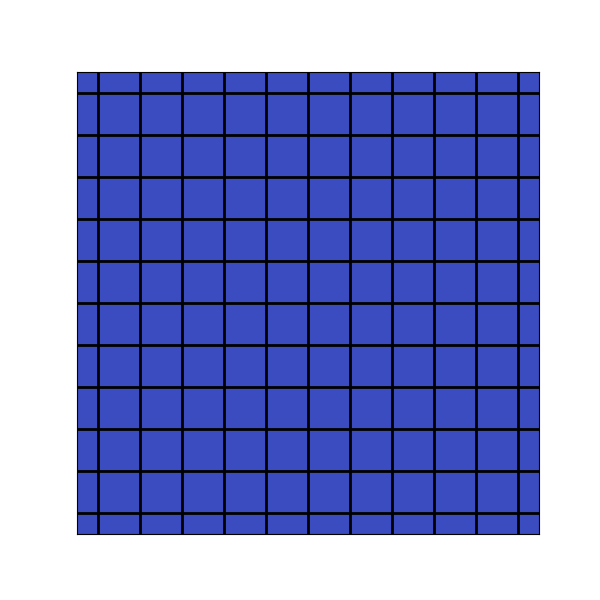

AI plays at 5, 5


In [8]:
%matplotlib widget

class InteractivePlay(object):
  def __init__(self, *, ai_player=None, ai_first=False):
    self.ai_player = ai_player
    self.position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32)
    self.ai_first = ai_first
    self.fig = None
    self.cid = None

  def _play_for_ai(self) -> Tuple[int, int]:
      ai_x, ai_y = self.ai_player(self.position, 2)
      assert self.position[ai_x, ai_y] == 0, f"AI player tried to play at {ai_x}, {ai_y} which is already taken."
      self.position[ai_x, ai_y] = 2
      print(f"AI plays at {ai_x}, {ai_y}")
      plt.plot(ai_x + 0.5, ai_y + 0.5, 'go', markersize=20)
      plt.draw()
      return ai_x, ai_y

  def update_board(self, event):
    # TODO: Handle Draw.
    x, y = int(event.xdata), int(event.ydata)
    if x < 0 or x >= BOARD_LENGTH or y < 0 or y >= BOARD_LENGTH:
        print("Out of board click. X=", x, "Y=", y)
        return
    if self.position[x, y] != 0:  # If the clicked cell is empty
        return
    
    self.position[x, y] = 1  # Place the player's piece
    print(f"Player plays at {x}, {y}")
    plt.plot(x + 0.5, y + 0.5, 'ro', markersize=20)
    plt.draw()
    # Check for win after updating the board
    if is_win(self.position, (x, y)):
        print(f"Player wins!")
        self.fig.canvas.mpl_disconnect(self.cid)  # Disable further clicks
        return

    ai_x, ai_y = self._play_for_ai()
    # Check for win after updating the board
    if is_win(self.position, (ai_x, ai_y)):
        print(f"AI wins!")
        self.fig.canvas.mpl_disconnect(self.cid)  # Disable further clicks
        return

  def display_board(self):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(torch.arange(BOARD_LENGTH) + 0.5, minor=True)
    ax.set_yticks(torch.arange(BOARD_LENGTH) + 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(self.position, cmap='coolwarm', extent=[0, BOARD_LENGTH, 0, BOARD_LENGTH])
    plt.gca().invert_yaxis()
    self.fig = fig
    self.cid = fig.canvas.mpl_connect('button_press_event', self.update_board)
    plt.show()
    if self.ai_first:
       self._play_for_ai()


play = InteractivePlay(ai_player=greedy_play, ai_first=True)
play.display_board()

In [299]:
class NNPolicy(nn.Module):
  def __init__(self, *, one_hot=True, he_init=True):
    super(NNPolicy, self).__init__()
    self.one_hot = one_hot
    conv1_in = 3 if one_hot else 1
    self.conv1 = nn.Conv2d(conv1_in, 32, kernel_size=9, padding=4)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) 
    self.conv_out = nn.Conv2d(256, 1, kernel_size=1)
    self.value_conv = nn.Conv2d(256, 1, kernel_size=1)
    self.value_out = nn.Linear(BOARD_LENGTH * BOARD_LENGTH, 1)
    if he_init:
      torch.nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv4.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv_out.weight)
      torch.nn.init.kaiming_uniform_(self.value_conv.weight)
      torch.nn.init.kaiming_uniform_(self.value_out.weight)

  def forward(self, x: torch.LongTensor):
    """
    Args:
      x: A LongTensor of shape [B, L, L] with value 0, 1 or 2.

    Return:
      A Tensor of shape [B, L * L] for the logits to play at each position.
    """
    assert x.dim() in [2, 3] and x.shape[-2:] == torch.Size([BOARD_LENGTH, BOARD_LENGTH]), f"Unsupported input shape {x.shape}"
    output_mask = torch.where(x == 0, 0, -torch.inf)
    if self.one_hot:
      space_channel = torch.where(x == 0, 1.0, 0.0)
      opponent_channel = torch.where(x == 1, 1.0, 0.0)
      player_channel = torch.where(x == 2, 1.0, 0.0)
      x = torch.stack([space_channel, opponent_channel, player_channel], dim=-3)
    else:
      x = x.float()
      x = x + 1  # leave value 0 for paddings
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    move_logits = self.conv_out(x).squeeze(-3) + output_mask
    x = F.relu(self.value_conv(x)).squeeze(-3)
    value = self.value_out(x.flatten(-2))
    return move_logits.flatten(-2), value
  

class PolicyPlayer(object):
  def __init__(self, policy: NNPolicy, greedy_play: bool=True):
    self.policy = policy
    self.greedy_play = greedy_play

  def play(self, position: torch.Tensor, current_player: int) -> torch.Tensor:
    self.policy.eval()
    with torch.no_grad():
      if (position != 0).all():
        return None
      assert current_player in [1, 2]
      # Always play as player 2 for simplicity.
      if current_player == 1:
        position = torch.where(position > 0, 3 - position, 0)
      logits, v = self.policy(position)
      # softmax the last 2 dims of the output
      action_probs = F.softmax(logits, dim=-1)
      if self.greedy_play:
        action_index = torch.argmax(action_probs)
      else:
        action_index = torch.multinomial(action_probs, 1)
    return torch.LongTensor([action_index // BOARD_LENGTH, action_index % BOARD_LENGTH])


# Test the PolicyPlayer and NNPolicy
print(PolicyPlayer(NNPolicy(), greedy_play=False).play(torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32), 1))
print(NNPolicy()(torch.zeros([BOARD_LENGTH, BOARD_LENGTH])))
print(sum(math.prod(p.shape) for p in NNPolicy().parameters()))

tensor([7, 8])
(tensor([ 0.0565,  0.0790,  0.3006,  0.1553,  0.3102,  0.3436,  0.1762,  0.1556,
         0.0446,  0.1758,  0.0299, -0.0668, -0.4540, -0.1120, -0.3029,  0.0256,
         0.1400,  0.0032, -0.0588,  0.0712,  0.1524,  0.1037, -0.0980, -0.5739,
        -0.2068, -0.6446, -0.3081, -0.2462, -0.4278, -0.4266, -0.2370,  0.1261,
         0.1113, -0.0078, -0.5777,  0.0899, -0.4343, -0.1840, -0.2700, -0.2944,
        -0.3709, -0.1072,  0.1910, -0.0863, -0.1181, -0.5935, -0.0409, -0.4437,
        -0.4560, -0.5503, -0.7158, -0.7373, -0.4535, -0.1231, -0.1307, -0.1057,
        -0.5360,  0.0241, -0.1943, -0.1852,  0.0064, -0.2797, -0.3044, -0.1889,
        -0.0716,  0.0366, -0.3065, -0.5963, -0.3511, -0.6164, -0.2700,  0.0088,
        -0.2302, -0.3371, -0.4319, -0.1532,  0.0076, -0.2083, -0.5052, -0.3987,
        -0.6141, -0.2352, -0.1151, -0.4309, -0.4107, -0.5605, -0.2032, -0.0583,
        -0.1369, -0.6800, -0.7035, -0.9544, -0.8605, -0.5235, -0.4770, -0.4570,
        -0.4156, -0.2093

In [270]:
def scrape_player(
    player: Callable[[torch.LongTensor, int], torch.LongTensor],
    random_play=0,
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    positions = []  # tensors of shape [BOARD_LENGTH, BOARD_LENGTH]
    labels = []  # actions, tensors of (x, y) indices
    wins = []  # episode tensors of value -1, 0, 1 for loss, draw, win
    i = 0
    progress = tqdm(total=BOARD_LENGTH * BOARD_LENGTH * (1 + random_play))
    for i in range(BOARD_LENGTH):
        for j in range(BOARD_LENGTH):
            base_position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.long)
            base_position[i, j] = 1
            current_player = 2
            play_index = torch.LongTensor([i, j])
            stone_num = 1
            next_plays = [-1]
            if random_play:
                random_plays = np.random.choice(
                    BOARD_LENGTH * BOARD_LENGTH, random_play, replace=False
                )
                next_plays.extend(random_plays)
            for next_play in next_plays:
                position = base_position.clone()
                if next_play >= 0:
                    row = next_play // BOARD_LENGTH
                    column = next_play % BOARD_LENGTH
                    position[row, column] = 2
                    current_player = 1
                    play_index = torch.LongTensor([row, column])
                    stone_num = 2
                episode_players = []
                win_player = 0
                while stone_num < BOARD_LENGTH * BOARD_LENGTH and win_player == 0:
                    play_index = player(position, current_player)
                    stone_num += 1
                    # Always play as player 2 for simplicity.
                    if current_player == 1:
                        position_input = torch.where(position > 0, 3 - position, 0)
                    else:
                        position_input = position.clone()
                    positions.append(position_input)
                    labels.append(play_index.clone())
                    episode_players.append(current_player)
                    position[play_index[0], play_index[1]] = current_player
                    if is_win(position, play_index):
                        win_player = current_player
                    current_player = 3 - current_player
                if win_player == 0:  # draw game
                    episode_win = torch.zeros(
                        size=[len(episode_players)], dtype=torch.long
                    )
                else:
                    episode_win = torch.where(
                        torch.tensor(episode_players, dtype=torch.long) == win_player,
                        1,
                        -1,
                    ).to(torch.long)
                wins.append(episode_win)
                progress.update()
    wins_tensor = torch.concat(wins)
    assert wins_tensor.shape[0] == len(positions)
    return torch.stack(positions), torch.stack(labels), wins_tensor


with torch.no_grad():
  scraped_positions, scraped_moves, scraped_results = scrape_player(greedy_play, random_play=100)

  0%|          | 0/12221 [00:00<?, ?it/s]

In [271]:
# torch.save(scraped_positions, "gomoku_scraped_positions.pth")
# torch.save(scraped_moves, "gomoku_scraped_moves.pth")
# torch.save(scraped_results, "gomoku_scraped_results.pth")
scraped_positions = torch.load("gomoku_scraped_positions.pth")
scraped_moves = torch.load("gomoku_scraped_moves.pth")
scraped_results = torch.load("gomoku_scraped_results.pth")
len(scraped_positions)

441178

In [276]:
def train(
    policy: NNPolicy,
    train_positions: torch.Tensor,
    train_labels: torch.Tensor,
    train_rewards: torch.Tensor,
    test_split=0.01,
    lr=0.01,
    lr_warmup_steps=100,
    epochs=1,
    batch_size=512,
    train_value_head=True,
    print_loss_every_steps=100,
) -> NNPolicy:
    # train test split
    assert len(train_positions) == len(train_labels)
    # flatten the label indices from [row, column] to a single index
    train_labels = train_labels[..., 0] * BOARD_LENGTH + train_labels[..., 1]

    N = len(train_positions)
    test_N = int(N * test_split)
    train_N = N - test_N
    perm = torch.randperm(N)
    test_indices = perm[:test_N]
    train_indices = perm[test_N:]
    test_positions = train_positions[test_indices]
    test_labels = train_labels[test_indices]
    test_rewards = train_rewards[test_indices]
    train_positions = train_positions[train_indices]
    train_labels = train_labels[train_indices]
    train_rewards = train_rewards[train_indices]

    policy.train()
    optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)
    def lr_lambda(current_step: int):
        if current_step < lr_warmup_steps:
            return float(current_step) / float(max(1, lr_warmup_steps))
        return 1.0
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    for epoch in range(epochs):
        perm = torch.randperm(train_N)
        for batch_begin in range(0, train_N - batch_size, batch_size):
            step = batch_begin // batch_size
            batch_indices = perm[batch_begin : batch_begin + batch_size]
            batch_input = train_positions[batch_indices]
            batch_label = train_labels[batch_indices]
            batch_rewards = train_rewards[batch_indices]

            optimizer.zero_grad()
            logits, v = policy(batch_input)
            logits = logits.view(-1, BOARD_LENGTH * BOARD_LENGTH)
            action_loss = F.cross_entropy(logits, target=batch_label)
            if train_value_head:
                value_loss = F.mse_loss(v.squeeze(-1), batch_rewards.to(torch.float))
                loss = value_loss + action_loss
                if step < 50 or step % print_loss_every_steps == 0:
                    print(f"Epoch {epoch} step {step}: action_loss={action_loss} value_loss={value_loss}")
            else:
                loss = action_loss
                if step < 50 or step % print_loss_every_steps == 0:
                    print(f"Epoch {epoch} step {step}: loss={action_loss}")
            loss.backward()

            optimizer.step()
            scheduler.step()
        test_logits, test_v = policy(test_positions)
        test_logits = test_logits.view(-1, BOARD_LENGTH * BOARD_LENGTH)
        test_action_loss = F.cross_entropy(test_logits, target=test_labels)
        test_value_loss = F.mse_loss(test_v, test_rewards)
        print(f"Epoch {epoch}: test_action_loss={test_action_loss} test_value_loss={test_value_loss}")

    return policy

trained_policy = train(
    NNPolicy(),
    scraped_positions,
    scraped_moves,
    scraped_results,
    lr_warmup_steps=100,
)

Epoch 0 step 0: action_loss=4.450185298919678 value_loss=1.0107228755950928
Epoch 0 step 1: action_loss=4.444716930389404 value_loss=0.9080188274383545
Epoch 0 step 2: action_loss=4.363085746765137 value_loss=0.8061984777450562
Epoch 0 step 3: action_loss=4.307687282562256 value_loss=0.7849788665771484
Epoch 0 step 4: action_loss=4.2507805824279785 value_loss=0.7767808437347412
Epoch 0 step 5: action_loss=4.159677505493164 value_loss=0.7981355786323547
Epoch 0 step 6: action_loss=4.1376519203186035 value_loss=0.7899563908576965
Epoch 0 step 7: action_loss=4.060267448425293 value_loss=0.779101550579071
Epoch 0 step 8: action_loss=4.034036636352539 value_loss=0.8251941204071045
Epoch 0 step 9: action_loss=3.9421069622039795 value_loss=0.8020758032798767
Epoch 0 step 10: action_loss=3.929428815841675 value_loss=0.7942673563957214
Epoch 0 step 11: action_loss=3.855156898498535 value_loss=0.7834046483039856
Epoch 0 step 12: action_loss=3.7524852752685547 value_loss=0.7822356820106506
Epoch 

/var/folders/c6/tvjpscjd4m96l0k_9kgcd2yh0000gn/T/ipykernel_7609/452352303.py:69: UserWarning: Using a target size (torch.Size([4411])) that is different to the input size (torch.Size([4411, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_value_loss = F.mse_loss(test_v, test_rewards)


In [277]:
# torch.save(trained_policy.state_dict(), "gomoku_trained.pth")
trained_policy = torch.load("gomoku_trained.pth")

## Findings from Supervised Learning
1. One-hot embedding is very important. Using a single integer to represent the board state took 10,000 steps for the loss to go down to 1.0. Using one-hot embedding took only 200 steps.
2. The model performed poorly in the later game as observed from the interactive plays. It started to ignore the 4-in-a-rows from the player's play. In the beginning, the model played well by following the greedy rule. It's not clear why the model performed poorly in the later game. It might be because the training data has a high coverage of the early games because all early games are short so they are similar. The later games are more diverse so the model might not have enough training data to learn. Another reason might be that the padding doesn't work well, and later game often happens near the border.
3. The model doesn't know where to put the first stone when it moves first. This is because the empty board state is not in the training data. We intentionally left the empty board as OOD, so that we can check if RL can get this fixed.

In [16]:
def head2head_ordered_eval(
    player1: AbstractPlayer,
    player2: AbstractPlayer,
    num_plays: int,
) -> Tuple[int, int, int]:
    win1, win2, draw = 0, 0, 0
    players = [player1, player2]

    for _ in range(num_plays):
        position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.long)
        position[BOARD_LENGTH // 2, BOARD_LENGTH // 2] = 1
        current_player = 2
        play_index = torch.LongTensor([BOARD_LENGTH // 2, BOARD_LENGTH // 2])
        stone_num = 1
        while stone_num < BOARD_LENGTH * BOARD_LENGTH:
            if is_win(position, play_index):
                if current_player == 1:
                    win2 += 1
                else:
                    win1 += 1
                break
            play_index = players[current_player - 1].play(position, current_player)
            stone_num += 1
            position[play_index[0], play_index[1]] = current_player
            current_player = 3 - current_player
        if stone_num == BOARD_LENGTH * BOARD_LENGTH:
            draw += 1
    return win1, win2, draw


def head2head_eval(
    player1: AbstractPlayer,
    player2: AbstractPlayer,
    *,
    num_plays: int = 100,
    verbose_output: bool = True,
    eval_name: str = "",
) -> float:
    p1f_w1, p1f_w2, p1f_draw = head2head_ordered_eval(
        player1, player2, num_plays=num_plays
    )
    if verbose_output:
        print(
            f"Player 1 goes first: player1_wins={p1f_w1} player2_wins={p1f_w2} draw={p1f_draw}"
        )
    p2f_w2, p2f_w1, p2f_draw = head2head_ordered_eval(
        player2, player1, num_plays=num_plays
    )
    if verbose_output:
        print(
            f"Player 2 goes first: player1_wins={p2f_w1} player2_wins={p2f_w2} draw={p2f_draw}"
        )
        print(
            f"Total: player1_wins={p1f_w1 + p2f_w1} player2_wins={p1f_w2 + p2f_w2} draw={p1f_draw + p2f_draw}"
        )
    initiative_win = p1f_w1 / num_plays
    init_draw = p1f_draw / num_plays
    follow_up_win = p2f_w1 / num_plays
    follow_draw = p2f_draw / num_plays
    total_win = (p1f_w1 + p2f_w1) / (num_plays * 2)
    total_lose = (p1f_w2 + p2f_w2) / (num_plays * 2)
    print(
        f"{eval_name} init_win={initiative_win:.2%} follow_win={follow_up_win:.2%} init_draw={init_draw:.2%} follow_draw={follow_draw:.2%} total_win={total_win:.2%} total_lose={total_lose:.2%}"
    )
    return total_win


head2head_eval(
    PolicyPlayer(trained_policy, greedy_play=True),
    PolicyPlayer(trained_policy, greedy_play=False),
)

Player 1 goes first: player1_wins=84 player2_wins=12 draw=4
Player 2 goes first: player1_wins=45 player2_wins=49 draw=6
Total: player1_wins=129 player2_wins=61 draw=10
 init_win=84.00% follow_win=45.00% init_draw=4.00% follow_draw=6.00% total_win=64.50% total_lose=30.50%


0.645

In [216]:
_ = head2head_eval(
    PolicyPlayer(trained_policy, greedy_play=True),
    RuleBasedPlayer(),
    num_plays=10,
)

Player 1 goes first: player1_wins=10 player2_wins=0 draw=0
Player 2 goes first: player1_wins=0 player2_wins=10 draw=0
Total: player1_wins=10 player2_wins=10 draw=0
 init_win=100.00% follow_win=0.00% init_draw=0.00% follow_draw=0.00% total_win=50.00% total_lose=50.00%


In [217]:
_ = head2head_eval(
    PolicyPlayer(trained_policy, greedy_play=False),
    RuleBasedPlayer(),
    num_plays=1000,
)

Player 1 goes first: player1_wins=408 player2_wins=592 draw=0
Player 2 goes first: player1_wins=39 player2_wins=961 draw=0
Total: player1_wins=447 player2_wins=1553 draw=0
 init_win=40.80% follow_win=3.90% init_draw=0.00% follow_draw=0.00% total_win=22.35% total_lose=77.65%


## More Findings from Supervised Learning
1. The supervised learning model is significantly worse than the rule based policy. While moving first the learned model only wins 20% of the time, while moving second it wins 0%.
2. The greedy action selection happens to be not good. It loses to the rule based policy even when it moves first.

In [188]:
DEFAULT_DRAW_REWARD = -0.01


class GomokuGame:
    """Game rule implementation that is compatible with the MCTS below."""

    _signature_weights = torch.pow(
        3, exponent=torch.arange(BOARD_LENGTH * BOARD_LENGTH)
    )

    def stringRepresentation(self, position: torch.LongTensor) -> int:
        return (position.flatten() @ self._signature_weights).detach().item()

    def getValidMoves(
        self, position: torch.LongTensor, not_used_player: int
    ) -> torch.LongTensor:
        return position.flatten().detach().numpy() == 0
    
    def getActionSize(self,) -> int:
        return BOARD_LENGTH * BOARD_LENGTH

    def getNextState(
        self, position: torch.LongTensor, current_player: int, action: int,
    ) -> torch.LongTensor:
        position = position.clone()
        position[action // BOARD_LENGTH, action % BOARD_LENGTH] = current_player
        return position, 3 - current_player
    
    def getGameEnded(
        self,
        position: torch.LongTensor,
        player: int,  # 1 or 2
    ) -> float:
        if is_player_win(position, player):
            return 1.0
        elif is_player_win(position, 3 - player):
            return -1.0
        elif torch.all(position != 0):
            return DEFAULT_DRAW_REWARD
        else:
            return 0.0  # not ended
        
    def getCanonicalForm(self, position, player):
        # Always play as player 2 for simplicity.
        if player == 1:
            return torch.where(position != 0, 3 - position, 0)
        else:
            return position


test_game = GomokuGame()
test_position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.long)
test_position[:, 0] = 1
test_position[:, 1] = 2
test_game.getValidMoves(test_position, 0)
test_position = torch.ones([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.long)
test_game.getGameEnded(test_position, 1)

1.0

In [190]:
class NumpyWrap():
    def __init__(self, nn: nn.Module):
        self.nn = nn

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        with torch.no_grad():
            t1, t2 = self.nn(*args, **kwds)
            p = F.softmax(t1, dim=-1)
            return p.numpy(), t2.item()


@dataclass
class MCTSArgs():
    numMCTSSims: int = 10
    cpuct: float = 1.0

# Below is copied from https://github.com/suragnair/alpha-zero-general/blob/master/MCTS.py

EPS = 1e-8

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}  # stores #times edge s,a was visited
        self.Ns = {}  # stores #times board s was visited
        self.Ps = {}  # stores initial policy (returned by neural net)

        self.Es = {}  # stores game.getGameEnded ended for board s
        self.Vs = {}  # stores game.getValidMoves for board s

    def getActionProb(self, canonicalBoard, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.

        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(canonicalBoard)

        s = self.game.stringRepresentation(canonicalBoard)
        counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

        if temp == 0:
            bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
            bestA = np.random.choice(bestAs)
            probs = [0] * len(counts)
            probs[bestA] = 1
            return probs

        counts = [x ** (1. / temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x / counts_sum for x in counts]
        return probs

    def search(self, canonicalBoard):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.

        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.

        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.

        Returns:
            v: the negative of the value of the current canonicalBoard
        """
        s = self.game.stringRepresentation(canonicalBoard)

        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
        if self.Es[s] != 0:
            # terminal node
            return -self.Es[s]

        if s not in self.Ps:
            # leaf node
            self.Ps[s], v = self.nnet(canonicalBoard)
            valids = self.game.getValidMoves(canonicalBoard, 1)
            self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s  # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable

                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print(f"All valid moves were masked, doing a workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return -v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s, a) in self.Qsa:
                    u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                            1 + self.Nsa[(s, a)])
                else:
                    u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
        next_s = self.game.getCanonicalForm(next_s, next_player)

        v = self.search(next_s)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            assert isinstance(self.Qsa[(s, a)], float), f"type(self.Qsa[(s, a)])={type(self.Qsa[(s, a)])}"
            self.Nsa[(s, a)] += 1

        else:
            self.Qsa[(s, a)] = v
            assert isinstance(self.Qsa[(s, a)], float), f"type(self.Qsa[(s, a)])={type(self.Qsa[(s, a)])}"
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1
        return -v

In [213]:
def self_play(
    policy: NNPolicy,
    *,
    policy_2: NNPolicy | None = None,
    draw_reward: float,
    split_reward: bool = False,
    first_player: int = 1,
    use_mcts: bool = False,
) -> Tuple[torch.Tensor, torch.Tensor, torch.LongTensor, torch.Tensor, int]:
    batch_logits = []
    batch_values = []
    batch_plays = []
    batch_players = []

    position = torch.zeros(size=(BOARD_LENGTH, BOARD_LENGTH), dtype=torch.long)
    current_player = first_player
    num_stones = 0
    win_player = 0
    if use_mcts:
        mcts = MCTS(GomokuGame(), NumpyWrap(policy), MCTSArgs())
    while num_stones < BOARD_LENGTH * BOARD_LENGTH:
        # Always play as player 2 for simplicity.
        if current_player == 1:
            position_tensor = torch.where(position > 0, 3 - position, 0).detach()
        else:
            position_tensor = position.detach()
        _policy = policy if current_player == 1 or not policy_2 else policy_2
        logits, position_v = _policy(position_tensor)
        flattened_logits = logits.view(BOARD_LENGTH * BOARD_LENGTH)
        if use_mcts:
            action_probs = mcts.getActionProb(position_tensor)
            to_play_flattend = np.random.choice(len(action_probs), p=action_probs)
            to_play_flattend = torch.tensor(to_play_flattend, dtype=torch.long)
        else:
            flattened_probs = F.softmax(flattened_logits, dim=-1)
            to_play_flattend = torch.multinomial(flattened_probs, 1)
        if current_player == 1 or not policy_2:
            batch_logits.append(flattened_logits)
            batch_values.append(position_v)
            batch_plays.append(to_play_flattend)
            batch_players.append(current_player)

        to_play_i = to_play_flattend.item() // BOARD_LENGTH
        to_play_j = to_play_flattend.item() % BOARD_LENGTH
        position[to_play_i, to_play_j] = current_player
        num_stones += 1
        if is_win(position, [to_play_i, to_play_j]):
            win_player = current_player
            break
        current_player = 3 - current_player
    _logits = torch.stack(batch_logits)
    _values = torch.stack(batch_values)
    _plays = torch.stack(batch_plays)
    batch_players_tensor = torch.LongTensor(batch_players)
    loss_player_stones = num_stones // 2
    win_player_stones = num_stones - loss_player_stones
    if win_player == 0:
        _rewards = (
            torch.ones_like(batch_players_tensor, dtype=torch.float) * draw_reward
        )
    elif split_reward:
        _rewards = torch.where(
            batch_players_tensor == win_player,
            1.0 / win_player_stones,
            -1.0 / loss_player_stones,
        )
    else:
        _rewards = torch.where(
            batch_players_tensor == win_player,
            1.0,
            -1.0,
        )
    return _logits, _values, _plays, _rewards, win_player

In [281]:
def reinforcement_learn(
    base_policy: NNPolicy,
    *,
    lr: float = 0.001,
    lr_schedule: str | None = None,
    batch_size: int = 64,
    steps: int = 16,
    draw_reward: float = DEFAULT_DRAW_REWARD,
    policy_as_player2: bool = True,
    fixed_opponent_policy: NNPolicy | None = None,
    opponent_update_win_rate: float = 0.55,
    use_mcts: bool = False,
    eval_every_steps: int = 1,
    return_snapshots: bool = False,
) -> nn.Module:
    if use_mcts:
        assert policy_as_player2, "MCTS with a fixed based model is not implemented."  
    policy = copy.deepcopy(base_policy)
    if fixed_opponent_policy:
        base_policy = fixed_opponent_policy
    base_policy.eval()
    optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)
    if not lr_schedule:
        scheduler = None
    elif lr_schedule == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=steps, eta_min=lr / 10
        )
    elif lr_schedule == "exponential":
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose=True)
    else:
        raise ValueError(f"Not supported lr_schedule: {lr_schedule}")

    base_policy_updates = 0
    snapshots = []
    for step in range(steps):
        all_logits = []
        all_values = []
        all_plays = []
        all_rewards = []
        policy.train()
        init_win_num = 0
        follow_up_win_num = 0
        draw_num = 0

        for b in range(batch_size):
            if policy_as_player2:
                batch_logits, batch_values, batch_plays, batch_rewards, win_player = self_play(
                    policy, draw_reward=draw_reward, use_mcts=use_mcts,
                )
            else:
                first_player = b % 2 + 1
                batch_logits, batch_values, batch_plays, batch_rewards, win_player = self_play(
                    policy, policy_2=base_policy, draw_reward=draw_reward, first_player=first_player,
                )
            all_logits.append(batch_logits)
            all_values.append(batch_values)
            all_plays.append(batch_plays)
            all_rewards.append(batch_rewards)
            if win_player == 0:
                draw_num += 1
            elif win_player == 1 and not policy_as_player2:
                if first_player == 1:
                    init_win_num += 1
                else:
                    follow_up_win_num += 1
        step_logits = torch.concat(all_logits)  # N, BL*BL
        step_values = torch.concat(all_values).squeeze(-1)
        step_plays = torch.concat(all_plays).squeeze().detach()  # N
        step_rewards = torch.concat(all_rewards).detach()  # N
        step_loss = F.cross_entropy(step_logits, step_plays, reduction="none")
        rl_loss = (step_loss * step_rewards).mean()
        if use_mcts:
            value_loss = F.mse_loss(step_values, step_rewards)
            final_loss = rl_loss + value_loss
            value_loss_print = f"value_loss={value_loss}"
        else:
            final_loss = rl_loss

        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        if not policy_as_player2:
            detailed_stats = f"i{init_win_num}f{follow_up_win_num}d{draw_num}"
        else:
            detailed_stats = f"d{draw_num}"
        print(
            f"Step {step}: trained on {len(step_logits)} plays({detailed_stats}). loss={rl_loss} {value_loss_print if use_mcts else ''}"
        )
        if not policy_as_player2 and not fixed_opponent_policy:
            win_rate = head2head_eval(
                PolicyPlayer(policy, greedy_play=False),
                PolicyPlayer(base_policy, greedy_play=False),
                verbose_output=False,
                eval_name="Against base: "
            )
            if win_rate > opponent_update_win_rate:
                print(f"<--Updating base policy.-->")
                base_policy = copy.deepcopy(policy)
                base_policy.eval()
                base_policy_updates += 1
        if step % eval_every_steps == 0:
            head2head_eval(
                PolicyPlayer(policy, greedy_play=False),
                RuleBasedPlayer(),
                verbose_output=False,
                eval_name="Against rule-based player: "
            )
            snapshots.append(copy.deepcopy(policy))
    print(f"RL train finished! Policy update steps = {base_policy_updates}")
    return snapshots if return_snapshots else policy

In [233]:
rl_trained_policy = reinforcement_learn(trained_policy)

Step 0: trained on 1996 plays(d0). loss=-0.03280669450759888 
Against rule-based player:  init_win=38.00% follow_win=4.00% init_draw=0.00% follow_draw=0.00% total_win=21.00% total_lose=79.00%
Step 1: trained on 1787 plays(d0). loss=-0.019377373158931732 
Against rule-based player:  init_win=49.00% follow_win=2.00% init_draw=0.00% follow_draw=0.00% total_win=25.50% total_lose=74.50%
Step 2: trained on 1729 plays(d0). loss=-0.03688858076930046 
Against rule-based player:  init_win=54.00% follow_win=0.00% init_draw=0.00% follow_draw=0.00% total_win=27.00% total_lose=73.00%
Step 3: trained on 1661 plays(d0). loss=-0.03354712575674057 
Against rule-based player:  init_win=66.00% follow_win=0.00% init_draw=0.00% follow_draw=0.00% total_win=33.00% total_lose=67.00%
Step 4: trained on 1874 plays(d0). loss=-0.057748615741729736 
Against rule-based player:  init_win=68.00% follow_win=0.00% init_draw=0.00% follow_draw=0.00% total_win=34.00% total_lose=66.00%
Step 5: trained on 2087 plays(d0). los

In [ ]:
# torch.save(rl_trained_policy.state_dict(), "gomoku_rl_1.pth")

In [262]:
head2head_eval(
    PolicyPlayer(rl_trained_policy, greedy_play=False),
    RuleBasedPlayer(),
    num_plays=1000,
)

Player 1 goes first: player1_wins=837 player2_wins=149 draw=14
Player 2 goes first: player1_wins=14 player2_wins=983 draw=3
Total: player1_wins=851 player2_wins=1132 draw=17
 init_win=83.70% follow_win=1.40% init_draw=1.40% follow_draw=0.30% total_win=42.55% total_lose=56.60%


0.4255

In [263]:
head2head_eval(
    PolicyPlayer(rl_trained_policy, greedy_play=False),
    PolicyPlayer(trained_policy, greedy_play=False),
    num_plays=1000,
)

Player 1 goes first: player1_wins=790 player2_wins=204 draw=6
Player 2 goes first: player1_wins=427 player2_wins=565 draw=8
Total: player1_wins=1217 player2_wins=769 draw=14
 init_win=79.00% follow_win=42.70% init_draw=0.60% follow_draw=0.80% total_win=60.85% total_lose=38.45%


0.6085

## Findings from Reinforcement Learning
1. For the first try, a reward is given for the win and a penalty is given for the loss. The draw games were dropped, which caused a problem. One explanation is that the policy quickly learned to avoid losses by playing defensively. During the following self-playing, the defensive policy played against another defensive policy, which caused a very high draw game ratio and no win/lose games for the policy to continue to learn.
2. After adding a small penalty(-0.01) to both players for the draw games, the RL algorithm works pretty well. A model trained from one of the RL training runs has reached a 50% win rate against the rule based policy.
3. RL training successfully fixed the issue of the first move. The model now knows to always put the first stone in the center.
4. However, the RL training is not very stable. Only one of the many training runs achieved comparable performance as the rule-based player. Other runs have some improvement in the middle but not in the end. Only comparing with a single rule-based player is a biased evaluation, but that's the only available evaluation method for now.
5. Tried smaller learning rate, cosine / exponential learning rate decay, smaller / larger batch sizes. Still not be able to steadily converging to the high performance model.
6. Need to add some analysis if time allows, such as plotting out the activation and gradient distribution changes on each steps. After identifying the reasons of instability, things to try can be prioritized including adding norms, dropout, full connected layers, l2 regularizations, residuals, and etc. Another direction is to make the RL more efficient, by exploring MCTS, actor-critic or other more advanced RL algorithms.
7. Given a model is already trained with quality on par with the rule based model, I think the model capacity is good enough.

## Further findings with regards to the stability:
1. Tried removed split reward by number of stones. Got another good model by luck. Stability is still an issue.
2. Introduced a base model as opponent in self-play as the Alpha-Go setup. The policy plays with a fixed base model which is a snapshot of itself. The backprop only goes to the policy model that is on one side of each play as opposed to both sides in the case where the opponent is also the policy itself. In theory, this process is expected to be more stable since the model only get updated when it's better than itself. However, in practice the finding is that the target policy might be updated to a stage where it always becomes worse after each step, so that the base model never gets updated.

In [259]:
rl_policy_with_fixed_base = reinforcement_learn(trained_policy, policy_as_player2=False, fixed_opponent_policy=rl_trained_policy)

Step 0: trained on 959 plays(i9f9d0). loss=-0.407124400138855 
Against rule-based player:  init_win=32.00% follow_win=0.00% init_draw=0.00% follow_draw=0.00% total_win=16.00% total_lose=84.00%
Step 1: trained on 1068 plays(i10f11d2). loss=-0.18172159790992737 
Against rule-based player:  init_win=23.00% follow_win=6.00% init_draw=0.00% follow_draw=0.00% total_win=14.50% total_lose=85.50%
Step 2: trained on 958 plays(i13f7d1). loss=-0.0989319458603859 
Against rule-based player:  init_win=28.00% follow_win=7.00% init_draw=0.00% follow_draw=0.00% total_win=17.50% total_lose=82.50%
Step 3: trained on 926 plays(i16f17d0). loss=0.07061976939439774 
Against rule-based player:  init_win=34.00% follow_win=8.00% init_draw=0.00% follow_draw=0.00% total_win=21.00% total_lose=79.00%
Step 4: trained on 911 plays(i16f15d0). loss=-0.05327298864722252 
Against rule-based player:  init_win=19.00% follow_win=11.00% init_draw=0.00% follow_draw=0.00% total_win=15.00% total_lose=85.00%
Step 5: trained on 8

In [260]:
head2head_eval(
    PolicyPlayer(rl_policy_with_fixed_base, greedy_play=False),
    PolicyPlayer(rl_trained_policy, greedy_play=False),
    num_plays=1000,
)

Player 1 goes first: player1_wins=709 player2_wins=289 draw=2
Player 2 goes first: player1_wins=385 player2_wins=613 draw=2
Total: player1_wins=1094 player2_wins=902 draw=4
 init_win=70.90% follow_win=38.50% init_draw=0.20% follow_draw=0.20% total_win=54.70% total_lose=45.10%


0.547

## Intransitivity
Tried to use the first successful RL policy (rl_trained_policy) as a fixed opponent to learn another policy(rl_policy_with_fixed_base). Head2head results showed some circular wins
   - rule_based_policy wins rl_policy_with_fixed_base by 80.05%
   - rl_policy_with_fixed_base wins rl_trained_policy by 57.6%
   - rl_trained_policy ties rule_based_policy
   This means that a policy can be trained to beat a specific opponent, but it's not guaranteed to be better than other possible policies. This is an intransitive game. This reveals 2 issues of the current LR setting:
   1) Using one fixed rule based policy for the h2h evaluation is a pretty biased evaluation.
   2) Using one single base policy in training is problematic. It's better to use a pool of models as the base policy. The Alpha-Go paper used a pool of models but it didn't mention why it stablizes the training.

In [289]:
mcts_trained_policy = reinforcement_learn(
    trained_policy, use_mcts=True,
)

Step 0: trained on 1006 plays(d0). loss=-0.911169171333313 value_loss=0.9993690848350525
Against rule-based player:  init_win=26.00% follow_win=1.00% init_draw=1.00% follow_draw=0.00% total_win=13.50% total_lose=86.00%
Step 1: trained on 1196 plays(d0). loss=-1.0305029153823853 value_loss=0.9995421171188354
Against rule-based player:  init_win=26.00% follow_win=2.00% init_draw=3.00% follow_draw=4.00% total_win=14.00% total_lose=82.50%
Step 2: trained on 1119 plays(d0). loss=-1.3956935405731201 value_loss=0.9994086027145386
Against rule-based player:  init_win=12.00% follow_win=2.00% init_draw=8.00% follow_draw=3.00% total_win=7.00% total_lose=87.50%
Step 3: trained on 1227 plays(d0). loss=-1.735711932182312 value_loss=0.9993572235107422
Against rule-based player:  init_win=11.00% follow_win=2.00% init_draw=30.00% follow_draw=8.00% total_win=6.50% total_lose=74.50%
Step 4: trained on 1516 plays(d0). loss=-1.1921594142913818 value_loss=0.9995474815368652
Against rule-based player:  init_

In [282]:
mcts_trained_policies = reinforcement_learn(
    trained_policy, use_mcts=True, return_snapshots=True)

Step 0: trained on 978 plays(d0). loss=-0.9526301622390747 value_loss=0.9992843270301819
Against rule-based player:  init_win=21.00% follow_win=1.00% init_draw=2.00% follow_draw=1.00% total_win=11.00% total_lose=87.50%
Step 1: trained on 1271 plays(d0). loss=-0.9089316129684448 value_loss=0.9996160268783569
Against rule-based player:  init_win=23.00% follow_win=3.00% init_draw=9.00% follow_draw=1.00% total_win=13.00% total_lose=82.00%
Step 2: trained on 1351 plays(d0). loss=-1.097440481185913 value_loss=0.9996745586395264
Against rule-based player:  init_win=12.00% follow_win=3.00% init_draw=19.00% follow_draw=3.00% total_win=7.50% total_lose=81.50%
Step 3: trained on 1585 plays(d0). loss=-1.0046199560165405 value_loss=0.9995349049568176
Against rule-based player:  init_win=12.00% follow_win=2.00% init_draw=20.00% follow_draw=9.00% total_win=7.00% total_lose=78.50%
Step 4: trained on 1570 plays(d1). loss=-1.312212347984314 value_loss=0.9224280714988708
Against rule-based player:  init_

## Findings with MCTS:
1. Adding MCTS does improve the stability! However, every time the RL training converged to a very defensive policy soon, then further trained to lose to the rule-based policy.
2. It's unclear why the model converges to defensive first. Diagonosing the cause is hard due to the intransitivity.

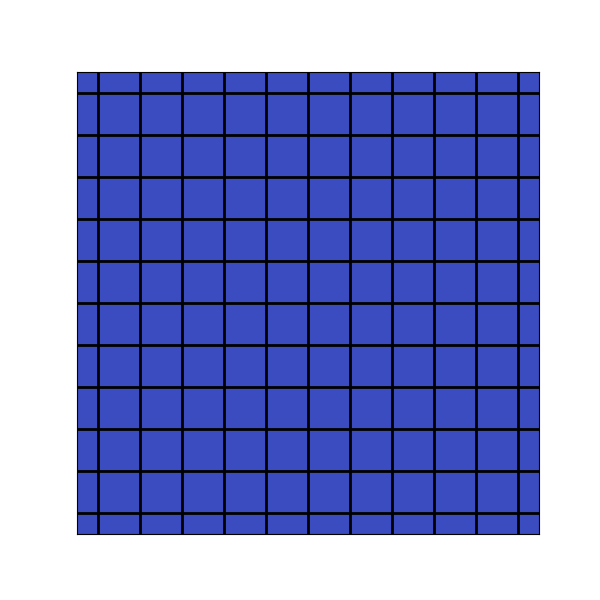

AI plays at 4, 4


Player plays at 5, 5
AI plays at 4, 5
Player plays at 4, 6
AI plays at 6, 4
Player plays at 6, 5
AI plays at 5, 4
Player plays at 3, 4
AI plays at 7, 4
Player plays at 8, 4
AI plays at 7, 5
Player plays at 8, 6
AI plays at 8, 5
Player plays at 9, 6
AI plays at 7, 6
Player plays at 7, 3
AI plays at 7, 7
Player plays at 7, 8
AI plays at 8, 7
Player plays at 6, 7
AI plays at 9, 10
Player plays at 5, 6
AI plays at 8, 9
Player plays at 5, 7
AI plays at 5, 9
Player plays at 3, 5
AI plays at 6, 8
Player plays at 4, 7
AI plays at 3, 7
Player plays at 3, 8
AI plays at 2, 9
Player plays at 3, 6
AI plays at 2, 6
Player plays at 4, 8
AI plays at 4, 9
Player plays at 3, 9
AI plays at 2, 10
Player plays at 2, 8
AI plays at 5, 8
Player plays at 1, 7
AI plays at 4, 10
Player plays at 1, 6
AI plays at 0, 6
Player plays at 1, 8
AI plays at 1, 9
Player plays at 0, 8
Player wins!


In [294]:
play = InteractivePlay(
  ai_player=PolicyPlayer(mcts_trained_policies[6], greedy_play=False).play,
  ai_first=True,
)
play.display_board()

# Conclusions
The RL training in this notbook improved the Gomoku policy performance siginficantly on top of the supervised learning. This notebook only explored the RL training within a small amount of computation. Only 1024 episodes (16 steps * batch size 64) are explored for each training run. The NN model size is also small, only ~500k parameters. At this scale, a lot of things already need to be right to make RL work.
  - What I have done and turned out useful:
    - One-hot embedding: improves model performance significantly
    - MCTS: Critical for stability
    - Small penalty for draw games: RL converges to local optimal quickly without this.
  - What look critical but I have not implemented yet:
    - A pool of base policies for training and evaluation.
    - Adjusting rewards to avoid defensive policy.
  - What I hope the policy can learn if more computation is available:
    - The policy should learn some strategies that human often use, such as the "double three" and "four three" rules. In order to learn these strategies, multiple consecutive moves that construct a human stategy need to happen in the stochastic self-play multiple times. This requires many magnitudes of more iterations as well as a much larger model capacity to remember the patterns.
  